# Player - Ground contact image classification - training

In [38]:
import os
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from torch.optim import Adam, lr_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from torchvision import datasets, transforms
import torchvision.models as models
from sklearn.metrics import matthews_corrcoef

## Load Data

In [39]:
DATASET_DIR = "dataset"

# # player tracking
# train_player_tracking_df = pd.read_csv(os.path.join(DATASET_DIR, "train_player_tracking.csv"), 
#                                        parse_dates=["datetime"])
# test_player_tracking_df = pd.read_csv(os.path.join(DATASET_DIR, "test_player_tracking.csv"), 
#                                       parse_dates=["datetime"])

# # helmet detection
# train_helmet_detection_df = pd.read_csv(os.path.join(DATASET_DIR, "train_baseline_helmets.csv"))
# test_helmet_detection_df = pd.read_csv(os.path.join(DATASET_DIR, "test_baseline_helmets.csv"))

# # video metadata
# train_video_metadata_df = pd.read_csv(os.path.join(DATASET_DIR, "train_video_metadata.csv"), 
#                                       parse_dates=["start_time", "end_time", "snap_time"])
# test_video_metadata_df = pd.read_csv(os.path.join(DATASET_DIR, "test_video_metadata.csv"), 
#                                       parse_dates=["start_time", "end_time", "snap_time"])

# train labels
train_labels_df =  pd.read_csv(os.path.join(DATASET_DIR, "train_labels.csv"), 
                               parse_dates=["datetime"])

# contact reduced to p2p distance below threshold
train_contact_df_reduced = pd.read_csv(os.path.join(DATASET_DIR, "train_contact_df_reduced.csv"))

# contact image
contact_image_endzone_df = pd.read_csv(os.path.join(DATASET_DIR, "train_contact_image_endzone_df.csv"))

## The PlayerContact dataset

### Transform function
It converts the PIL Image into a Tensor and normalizes it using the mean and std values from Imagenet

In [40]:
# transforms
IMAGE_SIZE = 224 # Image size of resize when applying transforms.
# data augmentation for train set
image_transform_train = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(0, 45)),
        transforms.ColorJitter(brightness=.2, hue=.2),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

image_transform_test = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

## The PlayerContact Dataset Class
The PlayerContact dataset class takes the data from the folder and returns images

In [41]:
class PlayerContactDataset(Dataset):
    """
    PlayerContact dataset that returns an image
    """
    def __init__(self, data_dir, contact_df, view, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.contact_df = contact_df
        self.view = view
        
    def __getitem__(self, idx):
        # get the image
        row = self.contact_df.iloc[idx]
        img_path = os.path.join(self.data_dir, row['contact_id']+'_'+self.view+'.jpg')
        image = Image.open(img_path).convert('RGB')
        if (self.transform):
            image = self.transform(image)
        
        # get the class label
        label = torch.tensor(row['contact_truth'])
        
        return image, label
    
    def __len__(self):
        return len(self.contact_df)

### Prepare and split the data

In [42]:
# we want a dataset with 25% of positive contacts and 75% of negative contacts

# merge contact_df and contact_image_df
train_df = train_contact_df_reduced.merge(contact_image_endzone_df, 
                                 left_on=['contact_id'], 
                                 right_on=['contact_id'], 
                                 how='left').drop_duplicates()
# use only the rows where the crop was generated
train_df = train_df[train_df['crop_generated'] == True]
# get the ground contacts
train_df = train_df[train_df['nfl_player_id_2'] == -1]

# get all positive contacts
pos_df = train_df[train_df['contact_truth'] == 1]
num_pos = len(pos_df)

# retrieve a number of negative contacts = to 3 times the number of positive contacts
neg_df = train_df[train_df['contact_truth'] == 0].sample(num_pos, random_state=42)
# concatenate negative and positive contacts
train_df = pd.concat([pos_df, neg_df])

# train test split
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df

,contact_id,game_play,step,nfl_player_id_1,nfl_player_id_2,game_key,play_id,datetime,team_1,position_1,...,direction_2,orientation_2,acceleration_2,sa_2,p2p_distance,contact_truth,crop_generated,rewinded_frames,miss_helmet_dets,miss_player_dets
504881,58524_003049_18_52733_G,58524_003049,18,52733,-1,58524,3049,2021-09-19 19:30:25.700000+00:00,home,RB,...,0.0,0.0,0.0,0.0,999.0,0,True,0.0,0.0,0.0
163369,58225_003821_51_47802_G,58225_003821,51,47802,-1,58225,3821,2020-10-25 19:54:29.400000+00:00,home,DT,...,0.0,0.0,0.0,0.0,999.0,1,True,0.0,0.0,0.0
269741,58301_002369_12_42883_G,58301_002369,12,42883,-1,58301,2369,2020-11-10 03:00:53.700000+00:00,away,C,...,0.0,0.0,0.0,0.0,999.0,0,True,0.0,0.0,0.0
83962,58202_002335_29_46102_G,58202_002335,29,46102,-1,58202,2335,2020-09-27 18:50:43.100000+00:00,away,T,...,0.0,0.0,0.0,0.0,999.0,0,True,0.0,0.0,0.0
147032,58221_001269_27_43409_G,58221_001269,27,43409,-1,58221,1269,2020-10-04 17:59:09.600000+00:00,away,DT,...,0.0,0.0,0.0,0.0,999.0,0,True,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627772,58567_004074_19_46189_G,58567_004074,19,46189,-1,58567,4074,2021-10-08 03:27:16.200000+00:00,home,TE,...,0.0,0.0,0.0,0.0,999.0,0,True,30.0,0.0,0.0
162951,58225_003821_37_40326_G,58225_003821,37,40326,-1,58225,3821,2020-10-25 19:54:28+00:00,home,ILB,...,0.0,0.0,0.0,0.0,999.0,1,True,0.0,0.0,0.0
23518,58180_000986_91_45008_G,58180_000986,91,45008,-1,58180,986,2020-09-13 21:03:12.900000+00:00,away,LB,...,0.0,0.0,0.0,0.0,999.0,1,True,30.0,0.0,0.0
647500,58577_002486_55_44847_G,58577_002486,55,44847,-1,58577,2486,2021-10-10 22:00:23.900000+00:00,away,DT,...,0.0,0.0,0.0,0.0,999.0,1,True,0.0,0.0,0.0


In [43]:
# # merge contact_df and contact_image_df
# train_df = train_contact_df_reduced.merge(contact_image_endzone_df, 
#                                  left_on=['contact_id'], 
#                                  right_on=['contact_id'], 
#                                  how='left').drop_duplicates()
# # use only the rows where the crop was generated
# train_df = train_df[train_df['crop_generated'] == True]
# # get the ground contacts
# train_df = train_df[train_df['nfl_player_id_2'] == -1]

# # split the dataset
# train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# train_df

In [44]:
num_contacts = train_df['contact_truth'].sum()
print(f"There are {num_contacts} positive contacts with the ground in the train set")
print(f"{num_contacts / len(train_df)*100:.2f}% of contacts with the ground are positive on the train set")

There are 13019 positive contacts with the ground in the train set
49.90% of contacts with the ground are positive on the train set


### Create instance of the dataset specific to player-ground contact

In [45]:
DATA_PATH = os.path.join('dataset', 'train', 'crops')
# train
p_g_contact_dataset_train = PlayerContactDataset(DATA_PATH, train_df, 'Endzone', image_transform_train)
# test
p_g_contact_dataset_test = PlayerContactDataset(DATA_PATH, test_df, 'Endzone', image_transform_test)

### Utils to show image from dataset

In [46]:
def inverse_normalize(tensor, mean, std):
    for channel_tensor, c_mean, c_std in zip(tensor, mean, std):
        channel_tensor.mul_(c_std).add_(c_mean)
        # The normalize code -> channel_tensor.sub_(c_mean).div_(c_std)
        
    return tensor

def tensor_to_image(tensor, is_normalized=True):
    img = tensor
    if is_normalized:
        img = inverse_normalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    img = np.array(img).transpose(1, 2, 0)
    img = Image.fromarray((img*255).astype(np.uint8))
    
    return img

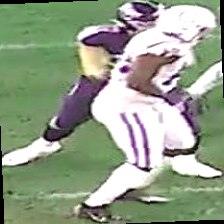

In [47]:
tensor_to_image(p_g_contact_dataset_train[700][0])

### Data Loaders

In [48]:
BATCH_SIZE = 32

loader_train = DataLoader(p_g_contact_dataset_train,
                         batch_size=BATCH_SIZE,
                         shuffle=True, 
                         num_workers=0,
                         drop_last=True) # drop last batch with size < 8 so that the batchnorm layers dont fail

loader_test = DataLoader(p_g_contact_dataset_test,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0,
                         drop_last=True)

In [49]:
# get one batch
images, labels = next(iter(loader_train))
# check the batch size
print(f'Batch size: {len(images)}')
print(f'Data shape: {images.shape}')
print("One batch of labels from the train loader:")
next(iter(loader_train))

Batch size: 32
Data shape: torch.Size([32, 3, 224, 224])
One batch of labels from the train loader:


[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

## Load the efficientnet model

In [50]:
def build_model(pretrained=True, fine_tune=True, num_classes=1):
    """
    Returns en efficientnetB0 classifier model
    """
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b0(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

In [51]:
model = build_model(num_classes=1) # 1 class for binary output

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


C:\Users\AT016638\.conda\envs\contact\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\AT016638\.conda\envs\contact\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model Training

### Training Utils

In [52]:
class Averager():
    """
    An Averager keeps track of the training and validation loss values
    and helps to get the average for each epoch as well
    """
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [53]:
def save_loss_plot(output_dir, mean_train_loss, mean_valid_loss, epoch_num, model_name):
    """
    Save plots with the loss curves of the model training
    """
    fig, ax = plt.subplots(figsize=(15,10))

    ax.plot(np.arange(epoch_num)+1, mean_train_loss, label='Training loss')
    ax.plot(np.arange(epoch_num)+1, mean_valid_loss, label='Validation Loss')
    
    ax.set_xticks(np.arange(1, epoch_num+1, step=1))
    if (epoch_num > 20):
        ax.set_xticks(np.arange(0, epoch_num+1, step=2))
    if(epoch_num > 50):
        ax.set_xticks(np.arange(0, epoch_num+1, step=5))
    if(epoch_num > 100):
        ax.set_xticks(np.arange(0, epoch_num+1, step=10))
    if(epoch_num > 1000):
        ax.set_xticks(np.arange(0, epoch_num+1, step=100))
        
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    ax.set_title('Loss Curves')
    ax.legend()
    fig.savefig(f"{output_dir}/{model_name}_epoch_loss.png")

    print('SAVING PLOTS COMPLETE...')

    plt.close('all')

In [54]:
def save_model(epoch, model, optimizer, model_name='model', out_dir='.'):
    """
    Function to save the trained model
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f'{out_dir}/{model_name}.pth')

    
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf'), model_name='model'
    ):
        self.best_valid_loss = best_valid_loss
        self.non_improve_iters = 0
        self.model_name = model_name
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, out_dir='.'
    ):
        if current_valid_loss < self.best_valid_loss:
            self.non_improve_iters = 0
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            model_name = f'bm_{self.model_name}_epoch_{epoch+1}'
            save_model(epoch, model, optimizer, model_name, out_dir)
        else:
            self.non_improve_iters += 1

### Training 1 epoch

In [55]:
def train_one_epoch(model, data_loader, criterion, optimizer, device, train_loss_averager):
    """
    Function that trains the given model for one epoch 
    with the given data loader
    """
    # activate model training mode in case its in evaluation mode
    model.train()
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    for i, (inputs, labels) in enumerate(prog_bar):
        # send data to device
        inputs = inputs.to(device)
        labels = labels.to(device).to(torch.float32)
        # reset the gradient accummulation from the previous batch
        optimizer.zero_grad()
        # make a prediction with the model
        prediction = model(inputs).to(torch.float32).squeeze(dim=1)
        # compute the loss 
        loss = criterion(prediction, labels)
        # save loss values to the averaher
        train_loss_averager.send(loss.item())
        # backpropagate the loss gradient
        loss.backward()
        # uptade parameters
        optimizer.step()

        # print the mean batch loss at each iteration
        prog_bar.set_description(desc=f"Training Loss: {train_loss_averager.value:.4f}")

### Validate Function

In [56]:
def validate_model(model, data_loader, criterion, device, val_loss_averager):
    """
    Uses the model on all the data from the data loader and 
    returns the predictions and the true targets. It also updates
    the loss averager
    """
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    loss_list = np.array([])
    total_predictions = torch.tensor([]).to(device)
    total_target_labels = torch.tensor([]).to(device)
    
    for i, (inputs, labels) in enumerate(prog_bar):
        # send data to device
        inputs = inputs.to(device)
        labels = labels.to(device).to(torch.float32)
        # make a prediction with the model in evaluation mode
        with torch.no_grad():
            # activate evaluation mode for batchnorm layers
            model.eval()
            prediction = model(inputs).to(torch.float32).squeeze(dim=1)

        # add batch predictions and true labels to total lists
        total_predictions = torch.cat((total_predictions, prediction), dim=0)    
        total_target_labels = torch.cat((total_target_labels, labels), dim=0)    
        # compute the loss 
        loss = criterion(prediction, labels)
        # update loss averager
        val_loss_averager.send(loss.item())
        
        # print the mean batch loss at each iteration
        prog_bar.set_description(desc=f"Validation Loss: {val_loss_averager.value:.4f}")

    # return total predictions and total true_labels
    return total_predictions, total_target_labels

### Constants

In [57]:
CLASSES = ['0', '1']
# detect the device (GPU or CPU)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# set the number of epochs
EPOCHS = 100
# set the learning rate
LR = 0.0001
# maximum iterations with no validation set improvement until early stoping
EARLY_STOP= 5

MODEL_NAME = 'efficientnet_CLS_ground_v5'
MODEL_DIR = 'trained_models'
PLOT_DIR = 'training_plots'

!mkdir {MODEL_DIR}
!mkdir {PLOT_DIR}

A subdirectory or file trained_models already exists.
A subdirectory or file training_plots already exists.


### Main training loop

In [58]:
# TRAINING PARAMS
# initialize model and send to device
model = build_model(num_classes=1) # 1 output for binary prediction
model = model.to(DEVICE)
# initialize Adam optimizer with default parameters (like the paper)
optimizer = Adam(model.parameters(), lr=LR)
# so it halves the learning rate every 5 epochs
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0, total_iters=EPOCHS)
# initialize loss function (sigmoid + binary cross entropy)
criterion = nn.BCEWithLogitsLoss()

# initialize the loss Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
# initialize SaveBestModel class
save_best_model = SaveBestModel(model_name=MODEL_NAME)
# mean losses for train and validation at every epoch
mean_train_losses = []
mean_validation_losses = []

# epoch loop
for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch+1}")
    # reset the training and valitation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # start timer and carry out training and evaluation
    start = time.time()
    # train one epoch
    train_one_epoch(model, loader_train, criterion, optimizer, 
                    DEVICE, train_loss_hist)
    # update the lr scheduler
    scheduler.step()
    #evaluate the model
    y_pred, y_true = validate_model(model, loader_test, criterion,
                                    DEVICE, val_loss_hist)
    
    print(f"Epoch #{epoch+1} train_loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation_loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {(end - start):.3f} seconds for epoch {epoch+1}")

    # save the mean train and validation losses of this epoch
    mean_train_losses.append(train_loss_hist.value)
    mean_validation_losses.append(val_loss_hist.value)

    # save the best model until now if we have the minimum val loss this epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer, 
                    out_dir=MODEL_DIR)
    
    #save the current epoch model
    save_model(epoch, model, optimizer, model_name=MODEL_NAME,
               out_dir=MODEL_DIR)

    #save the loss plot
    save_loss_plot('training_plots', mean_train_losses, mean_validation_losses, 
                   epoch+1, MODEL_NAME)
    print('\n')

print('Training done')

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...
Starting epoch 1


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #1 train_loss: 0.470
Epoch #1 validation_loss: 0.375
Took 260.366 seconds for epoch 1

Best validation loss: 0.37510230190354615

Saving best model for epoch: 1

SAVING PLOTS COMPLETE...


Starting epoch 2


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #2 train_loss: 0.396
Epoch #2 validation_loss: 0.359
Took 260.376 seconds for epoch 2

Best validation loss: 0.3593340690059615

Saving best model for epoch: 2

SAVING PLOTS COMPLETE...


Starting epoch 3


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #3 train_loss: 0.366
Epoch #3 validation_loss: 0.339
Took 254.398 seconds for epoch 3

Best validation loss: 0.3388734054682877

Saving best model for epoch: 3

SAVING PLOTS COMPLETE...


Starting epoch 4


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #4 train_loss: 0.343
Epoch #4 validation_loss: 0.334
Took 253.017 seconds for epoch 4

Best validation loss: 0.334123065685991

Saving best model for epoch: 4

SAVING PLOTS COMPLETE...


Starting epoch 5


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #5 train_loss: 0.320
Epoch #5 validation_loss: 0.327
Took 247.777 seconds for epoch 5

Best validation loss: 0.3274333804772405

Saving best model for epoch: 5

SAVING PLOTS COMPLETE...


Starting epoch 6


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #6 train_loss: 0.301
Epoch #6 validation_loss: 0.328
Took 250.340 seconds for epoch 6
SAVING PLOTS COMPLETE...


Starting epoch 7


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #7 train_loss: 0.278
Epoch #7 validation_loss: 0.325
Took 249.538 seconds for epoch 7

Best validation loss: 0.32471356896931314

Saving best model for epoch: 7

SAVING PLOTS COMPLETE...


Starting epoch 8


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #8 train_loss: 0.262
Epoch #8 validation_loss: 0.323
Took 249.398 seconds for epoch 8

Best validation loss: 0.32345497109032617

Saving best model for epoch: 8

SAVING PLOTS COMPLETE...


Starting epoch 9


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #9 train_loss: 0.247
Epoch #9 validation_loss: 0.313
Took 249.408 seconds for epoch 9

Best validation loss: 0.31321333183590416

Saving best model for epoch: 9

SAVING PLOTS COMPLETE...


Starting epoch 10


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #10 train_loss: 0.232
Epoch #10 validation_loss: 0.323
Took 247.940 seconds for epoch 10
SAVING PLOTS COMPLETE...


Starting epoch 11


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #11 train_loss: 0.214
Epoch #11 validation_loss: 0.331
Took 247.251 seconds for epoch 11
SAVING PLOTS COMPLETE...


Starting epoch 12


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #12 train_loss: 0.203
Epoch #12 validation_loss: 0.318
Took 246.495 seconds for epoch 12
SAVING PLOTS COMPLETE...


Starting epoch 13


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #13 train_loss: 0.188
Epoch #13 validation_loss: 0.347
Took 248.727 seconds for epoch 13
SAVING PLOTS COMPLETE...


Starting epoch 14


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #14 train_loss: 0.179
Epoch #14 validation_loss: 0.339
Took 250.390 seconds for epoch 14
SAVING PLOTS COMPLETE...


Starting epoch 15


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #15 train_loss: 0.173
Epoch #15 validation_loss: 0.348
Took 251.082 seconds for epoch 15
SAVING PLOTS COMPLETE...


Starting epoch 16


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #16 train_loss: 0.159
Epoch #16 validation_loss: 0.351
Took 248.059 seconds for epoch 16
SAVING PLOTS COMPLETE...


Starting epoch 17


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #17 train_loss: 0.152
Epoch #17 validation_loss: 0.380
Took 247.583 seconds for epoch 17
SAVING PLOTS COMPLETE...


Starting epoch 18


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #18 train_loss: 0.147
Epoch #18 validation_loss: 0.395
Took 247.639 seconds for epoch 18
SAVING PLOTS COMPLETE...


Starting epoch 19


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #19 train_loss: 0.141
Epoch #19 validation_loss: 0.380
Took 249.187 seconds for epoch 19
SAVING PLOTS COMPLETE...


Starting epoch 20


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #20 train_loss: 0.132
Epoch #20 validation_loss: 0.417
Took 247.654 seconds for epoch 20
SAVING PLOTS COMPLETE...


Starting epoch 21


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #21 train_loss: 0.131
Epoch #21 validation_loss: 0.392
Took 249.837 seconds for epoch 21
SAVING PLOTS COMPLETE...


Starting epoch 22


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #22 train_loss: 0.125
Epoch #22 validation_loss: 0.401
Took 254.330 seconds for epoch 22
SAVING PLOTS COMPLETE...


Starting epoch 23


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #23 train_loss: 0.118
Epoch #23 validation_loss: 0.406
Took 257.504 seconds for epoch 23
SAVING PLOTS COMPLETE...


Starting epoch 24


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #24 train_loss: 0.115
Epoch #24 validation_loss: 0.400
Took 246.405 seconds for epoch 24
SAVING PLOTS COMPLETE...


Starting epoch 25


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #25 train_loss: 0.109
Epoch #25 validation_loss: 0.418
Took 248.885 seconds for epoch 25
SAVING PLOTS COMPLETE...


Starting epoch 26


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #26 train_loss: 0.103
Epoch #26 validation_loss: 0.444
Took 247.546 seconds for epoch 26
SAVING PLOTS COMPLETE...


Starting epoch 27


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #27 train_loss: 0.103
Epoch #27 validation_loss: 0.437
Took 248.025 seconds for epoch 27
SAVING PLOTS COMPLETE...


Starting epoch 28


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #28 train_loss: 0.099
Epoch #28 validation_loss: 0.453
Took 248.518 seconds for epoch 28
SAVING PLOTS COMPLETE...


Starting epoch 29


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #29 train_loss: 0.095
Epoch #29 validation_loss: 0.442
Took 248.801 seconds for epoch 29
SAVING PLOTS COMPLETE...


Starting epoch 30


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #30 train_loss: 0.094
Epoch #30 validation_loss: 0.440
Took 249.243 seconds for epoch 30
SAVING PLOTS COMPLETE...


Starting epoch 31


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #31 train_loss: 0.094
Epoch #31 validation_loss: 0.446
Took 249.108 seconds for epoch 31
SAVING PLOTS COMPLETE...


Starting epoch 32


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #32 train_loss: 0.087
Epoch #32 validation_loss: 0.453
Took 248.520 seconds for epoch 32
SAVING PLOTS COMPLETE...


Starting epoch 33


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #33 train_loss: 0.084
Epoch #33 validation_loss: 0.473
Took 248.298 seconds for epoch 33
SAVING PLOTS COMPLETE...


Starting epoch 34


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #34 train_loss: 0.087
Epoch #34 validation_loss: 0.478
Took 248.340 seconds for epoch 34
SAVING PLOTS COMPLETE...


Starting epoch 35


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #35 train_loss: 0.081
Epoch #35 validation_loss: 0.493
Took 250.421 seconds for epoch 35
SAVING PLOTS COMPLETE...


Starting epoch 36


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #36 train_loss: 0.079
Epoch #36 validation_loss: 0.484
Took 248.700 seconds for epoch 36
SAVING PLOTS COMPLETE...


Starting epoch 37


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #37 train_loss: 0.074
Epoch #37 validation_loss: 0.503
Took 249.509 seconds for epoch 37
SAVING PLOTS COMPLETE...


Starting epoch 38


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #38 train_loss: 0.076
Epoch #38 validation_loss: 0.503
Took 250.244 seconds for epoch 38
SAVING PLOTS COMPLETE...


Starting epoch 39


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #39 train_loss: 0.075
Epoch #39 validation_loss: 0.497
Took 248.882 seconds for epoch 39
SAVING PLOTS COMPLETE...


Starting epoch 40


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #40 train_loss: 0.071
Epoch #40 validation_loss: 0.514
Took 249.078 seconds for epoch 40
SAVING PLOTS COMPLETE...


Starting epoch 41


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #41 train_loss: 0.070
Epoch #41 validation_loss: 0.536
Took 253.528 seconds for epoch 41
SAVING PLOTS COMPLETE...


Starting epoch 42


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #42 train_loss: 0.070
Epoch #42 validation_loss: 0.495
Took 257.432 seconds for epoch 42
SAVING PLOTS COMPLETE...


Starting epoch 43


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #43 train_loss: 0.067
Epoch #43 validation_loss: 0.518
Took 254.264 seconds for epoch 43
SAVING PLOTS COMPLETE...


Starting epoch 44


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #44 train_loss: 0.065
Epoch #44 validation_loss: 0.529
Took 247.737 seconds for epoch 44
SAVING PLOTS COMPLETE...


Starting epoch 45


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #45 train_loss: 0.066
Epoch #45 validation_loss: 0.571
Took 247.914 seconds for epoch 45
SAVING PLOTS COMPLETE...


Starting epoch 46


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #46 train_loss: 0.061
Epoch #46 validation_loss: 0.590
Took 249.463 seconds for epoch 46
SAVING PLOTS COMPLETE...


Starting epoch 47


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #47 train_loss: 0.060
Epoch #47 validation_loss: 0.555
Took 248.427 seconds for epoch 47
SAVING PLOTS COMPLETE...


Starting epoch 48


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #48 train_loss: 0.063
Epoch #48 validation_loss: 0.564
Took 248.295 seconds for epoch 48
SAVING PLOTS COMPLETE...


Starting epoch 49


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #49 train_loss: 0.059
Epoch #49 validation_loss: 0.552
Took 248.612 seconds for epoch 49
SAVING PLOTS COMPLETE...


Starting epoch 50


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #50 train_loss: 0.057
Epoch #50 validation_loss: 0.575
Took 250.713 seconds for epoch 50
SAVING PLOTS COMPLETE...


Starting epoch 51


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #51 train_loss: 0.055
Epoch #51 validation_loss: 0.572
Took 256.966 seconds for epoch 51
SAVING PLOTS COMPLETE...


Starting epoch 52


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #52 train_loss: 0.053
Epoch #52 validation_loss: 0.575
Took 255.741 seconds for epoch 52
SAVING PLOTS COMPLETE...


Starting epoch 53


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #53 train_loss: 0.054
Epoch #53 validation_loss: 0.587
Took 248.235 seconds for epoch 53
SAVING PLOTS COMPLETE...


Starting epoch 54


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #54 train_loss: 0.051
Epoch #54 validation_loss: 0.615
Took 248.692 seconds for epoch 54
SAVING PLOTS COMPLETE...


Starting epoch 55


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #55 train_loss: 0.052
Epoch #55 validation_loss: 0.572
Took 248.203 seconds for epoch 55
SAVING PLOTS COMPLETE...


Starting epoch 56


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #56 train_loss: 0.050
Epoch #56 validation_loss: 0.601
Took 248.716 seconds for epoch 56
SAVING PLOTS COMPLETE...


Starting epoch 57


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #57 train_loss: 0.048
Epoch #57 validation_loss: 0.618
Took 248.564 seconds for epoch 57
SAVING PLOTS COMPLETE...


Starting epoch 58


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #58 train_loss: 0.048
Epoch #58 validation_loss: 0.628
Took 249.013 seconds for epoch 58
SAVING PLOTS COMPLETE...


Starting epoch 59


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #59 train_loss: 0.047
Epoch #59 validation_loss: 0.613
Took 248.852 seconds for epoch 59
SAVING PLOTS COMPLETE...


Starting epoch 60


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #60 train_loss: 0.046
Epoch #60 validation_loss: 0.645
Took 250.918 seconds for epoch 60
SAVING PLOTS COMPLETE...


Starting epoch 61


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #61 train_loss: 0.047
Epoch #61 validation_loss: 0.619
Took 250.098 seconds for epoch 61
SAVING PLOTS COMPLETE...


Starting epoch 62


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #62 train_loss: 0.043
Epoch #62 validation_loss: 0.657
Took 248.426 seconds for epoch 62
SAVING PLOTS COMPLETE...


Starting epoch 63


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #63 train_loss: 0.044
Epoch #63 validation_loss: 0.651
Took 248.373 seconds for epoch 63
SAVING PLOTS COMPLETE...


Starting epoch 64


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #64 train_loss: 0.044
Epoch #64 validation_loss: 0.647
Took 251.866 seconds for epoch 64
SAVING PLOTS COMPLETE...


Starting epoch 65


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #65 train_loss: 0.041
Epoch #65 validation_loss: 0.660
Took 248.863 seconds for epoch 65
SAVING PLOTS COMPLETE...


Starting epoch 66


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #66 train_loss: 0.041
Epoch #66 validation_loss: 0.680
Took 249.654 seconds for epoch 66
SAVING PLOTS COMPLETE...


Starting epoch 67


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #67 train_loss: 0.041
Epoch #67 validation_loss: 0.660
Took 257.356 seconds for epoch 67
SAVING PLOTS COMPLETE...


Starting epoch 68


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #68 train_loss: 0.041
Epoch #68 validation_loss: 0.675
Took 253.687 seconds for epoch 68
SAVING PLOTS COMPLETE...


Starting epoch 69


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #69 train_loss: 0.038
Epoch #69 validation_loss: 0.706
Took 251.763 seconds for epoch 69
SAVING PLOTS COMPLETE...


Starting epoch 70


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #70 train_loss: 0.040
Epoch #70 validation_loss: 0.695
Took 248.503 seconds for epoch 70
SAVING PLOTS COMPLETE...


Starting epoch 71


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #71 train_loss: 0.039
Epoch #71 validation_loss: 0.683
Took 249.676 seconds for epoch 71
SAVING PLOTS COMPLETE...


Starting epoch 72


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #72 train_loss: 0.036
Epoch #72 validation_loss: 0.685
Took 248.445 seconds for epoch 72
SAVING PLOTS COMPLETE...


Starting epoch 73


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #73 train_loss: 0.039
Epoch #73 validation_loss: 0.694
Took 249.344 seconds for epoch 73
SAVING PLOTS COMPLETE...


Starting epoch 74


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #74 train_loss: 0.037
Epoch #74 validation_loss: 0.700
Took 249.273 seconds for epoch 74
SAVING PLOTS COMPLETE...


Starting epoch 75


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #75 train_loss: 0.035
Epoch #75 validation_loss: 0.711
Took 249.600 seconds for epoch 75
SAVING PLOTS COMPLETE...


Starting epoch 76


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #76 train_loss: 0.034
Epoch #76 validation_loss: 0.720
Took 249.935 seconds for epoch 76
SAVING PLOTS COMPLETE...


Starting epoch 77


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #77 train_loss: 0.034
Epoch #77 validation_loss: 0.731
Took 249.295 seconds for epoch 77
SAVING PLOTS COMPLETE...


Starting epoch 78


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #78 train_loss: 0.034
Epoch #78 validation_loss: 0.738
Took 248.944 seconds for epoch 78
SAVING PLOTS COMPLETE...


Starting epoch 79


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #79 train_loss: 0.035
Epoch #79 validation_loss: 0.714
Took 251.384 seconds for epoch 79
SAVING PLOTS COMPLETE...


Starting epoch 80


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #80 train_loss: 0.033
Epoch #80 validation_loss: 0.709
Took 249.179 seconds for epoch 80
SAVING PLOTS COMPLETE...


Starting epoch 81


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #81 train_loss: 0.032
Epoch #81 validation_loss: 0.711
Took 249.109 seconds for epoch 81
SAVING PLOTS COMPLETE...


Starting epoch 82


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #82 train_loss: 0.033
Epoch #82 validation_loss: 0.748
Took 249.702 seconds for epoch 82
SAVING PLOTS COMPLETE...


Starting epoch 83


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #83 train_loss: 0.032
Epoch #83 validation_loss: 0.751
Took 249.464 seconds for epoch 83
SAVING PLOTS COMPLETE...


Starting epoch 84


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #84 train_loss: 0.032
Epoch #84 validation_loss: 0.727
Took 252.012 seconds for epoch 84
SAVING PLOTS COMPLETE...


Starting epoch 85


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #85 train_loss: 0.032
Epoch #85 validation_loss: 0.722
Took 249.725 seconds for epoch 85
SAVING PLOTS COMPLETE...


Starting epoch 86


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #86 train_loss: 0.031
Epoch #86 validation_loss: 0.719
Took 250.160 seconds for epoch 86
SAVING PLOTS COMPLETE...


Starting epoch 87


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #87 train_loss: 0.031
Epoch #87 validation_loss: 0.734
Took 249.208 seconds for epoch 87
SAVING PLOTS COMPLETE...


Starting epoch 88


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #88 train_loss: 0.031
Epoch #88 validation_loss: 0.730
Took 250.097 seconds for epoch 88
SAVING PLOTS COMPLETE...


Starting epoch 89


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #89 train_loss: 0.029
Epoch #89 validation_loss: 0.756
Took 249.908 seconds for epoch 89
SAVING PLOTS COMPLETE...


Starting epoch 90


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #90 train_loss: 0.029
Epoch #90 validation_loss: 0.750
Took 249.257 seconds for epoch 90
SAVING PLOTS COMPLETE...


Starting epoch 91


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #91 train_loss: 0.030
Epoch #91 validation_loss: 0.736
Took 251.150 seconds for epoch 91
SAVING PLOTS COMPLETE...


Starting epoch 92


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #92 train_loss: 0.028
Epoch #92 validation_loss: 0.729
Took 249.743 seconds for epoch 92
SAVING PLOTS COMPLETE...


Starting epoch 93


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #93 train_loss: 0.027
Epoch #93 validation_loss: 0.731
Took 252.486 seconds for epoch 93
SAVING PLOTS COMPLETE...


Starting epoch 94


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #94 train_loss: 0.027
Epoch #94 validation_loss: 0.748
Took 250.645 seconds for epoch 94
SAVING PLOTS COMPLETE...


Starting epoch 95


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #95 train_loss: 0.027
Epoch #95 validation_loss: 0.742
Took 249.237 seconds for epoch 95
SAVING PLOTS COMPLETE...


Starting epoch 96


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #96 train_loss: 0.028
Epoch #96 validation_loss: 0.729
Took 249.625 seconds for epoch 96
SAVING PLOTS COMPLETE...


Starting epoch 97


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #97 train_loss: 0.026
Epoch #97 validation_loss: 0.748
Took 249.829 seconds for epoch 97
SAVING PLOTS COMPLETE...


Starting epoch 98


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #98 train_loss: 0.027
Epoch #98 validation_loss: 0.748
Took 250.492 seconds for epoch 98
SAVING PLOTS COMPLETE...


Starting epoch 99


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #99 train_loss: 0.025
Epoch #99 validation_loss: 0.758
Took 249.610 seconds for epoch 99
SAVING PLOTS COMPLETE...


Starting epoch 100


  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch #100 train_loss: 0.026
Epoch #100 validation_loss: 0.759
Took 249.333 seconds for epoch 100
SAVING PLOTS COMPLETE...


Training done


Best valid loss: 0.31321


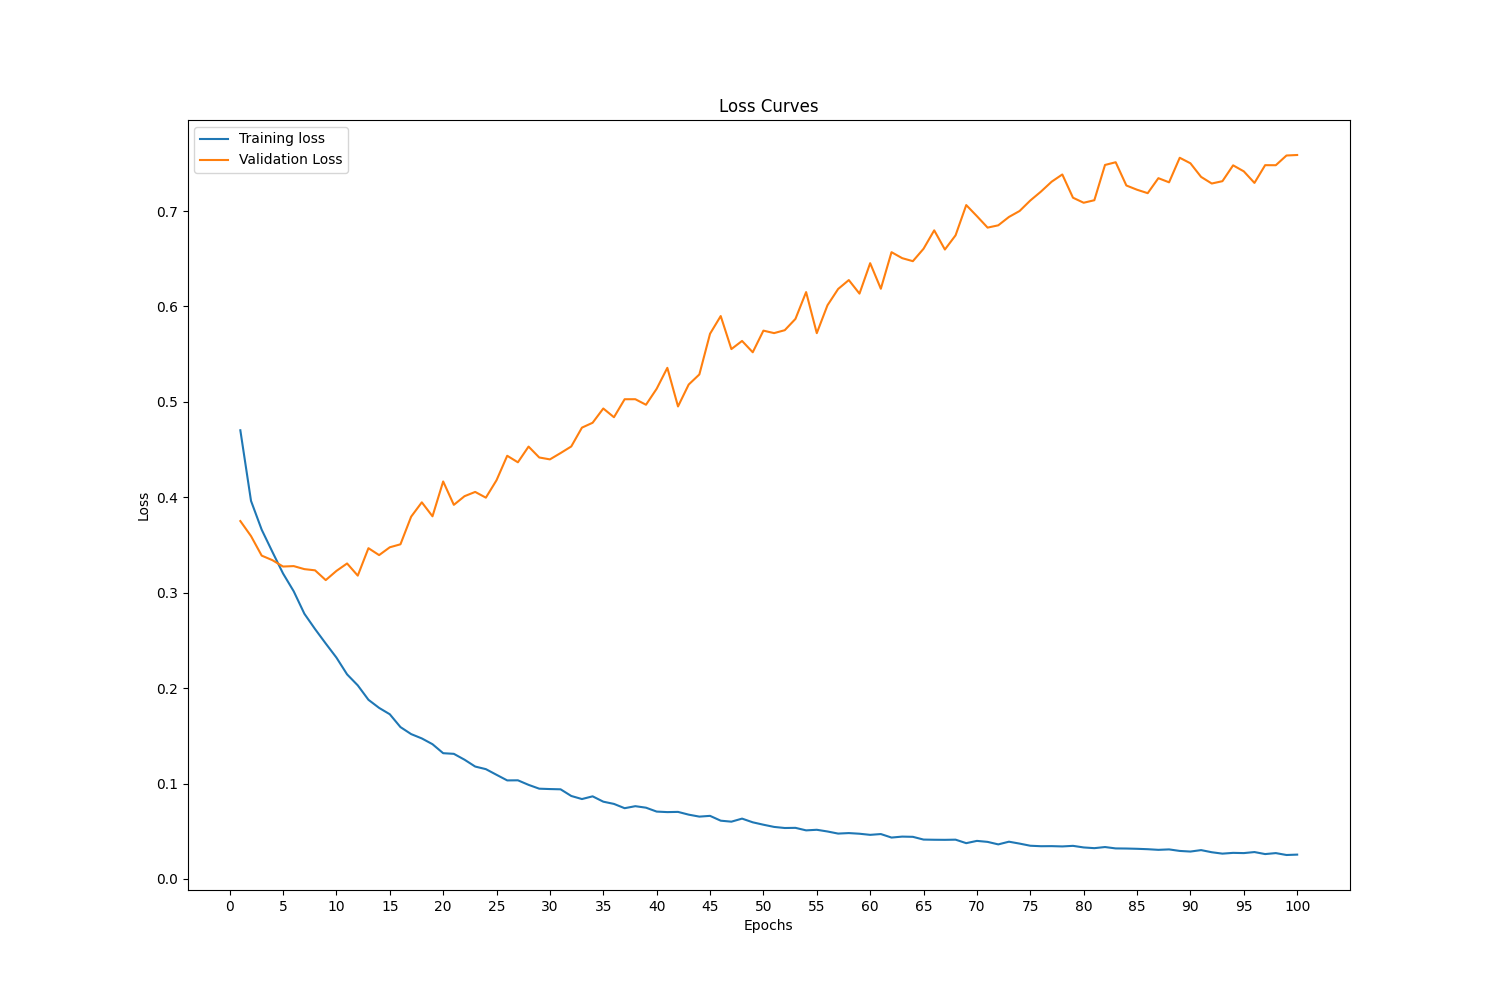

In [59]:
print(f"Best valid loss: {save_best_model.best_valid_loss:.5f}")
Image.open(f'{PLOT_DIR}/{MODEL_NAME}_epoch_loss.png')

## Check Predictions

### Load model

In [60]:
def load_model(model_path, num_classes, device):
    """
    Returns a efficientnet model with the weights from the saved model
    """
    model = models.efficientnet_b0(pretrained=True)
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device).eval();
    
    return model

In [61]:
#load the best model on the validation set
best_model_path = os.path.join(MODEL_DIR, 'bm_efficientnet_CLS_ground_v5_epoch_9.pth')
best_model = load_model(best_model_path, 1, DEVICE)

### Check validation set

In [62]:
val_loss_hist = Averager()
criterion = nn.BCEWithLogitsLoss()
y_pred, y_true = validate_model(best_model, loader_test, criterion,
                                    DEVICE, val_loss_hist)

  0%|          | 0/203 [00:00<?, ?it/s]

### Mathews correlation coefficient

In [63]:
# mathews correlation coefficient

thresholds = np.arange(0.0, 0.5, 0.01)
best_score = 0
best_thrs = -1
for thrs in thresholds:
    y_pred_clean = (torch.sigmoid(y_pred) > thrs).double()
    score = matthews_corrcoef(y_pred_clean.cpu(), y_true.cpu())
    if score > best_score:
        best_score = score
        best_thrs = thrs

y_pred_clean = (torch.sigmoid(y_pred) > best_thrs).double()
print(f"Best acc threshold: {best_thrs}")
print(f"Matheys corr coef: {best_score:.5f}")

Best acc threshold: 0.49
Matheys corr coef: 0.75300


### Confusion Matrix

In [64]:
def show_confusion_matrix(y_pred, y_true, display_labels, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                        display_labels=display_labels)

    fig, ax = plt.subplots(figsize=(15,15))
    plt.title(title)
    conf_display.plot(cmap=plt.cm.Blues, ax=ax);
    return conf_matrix

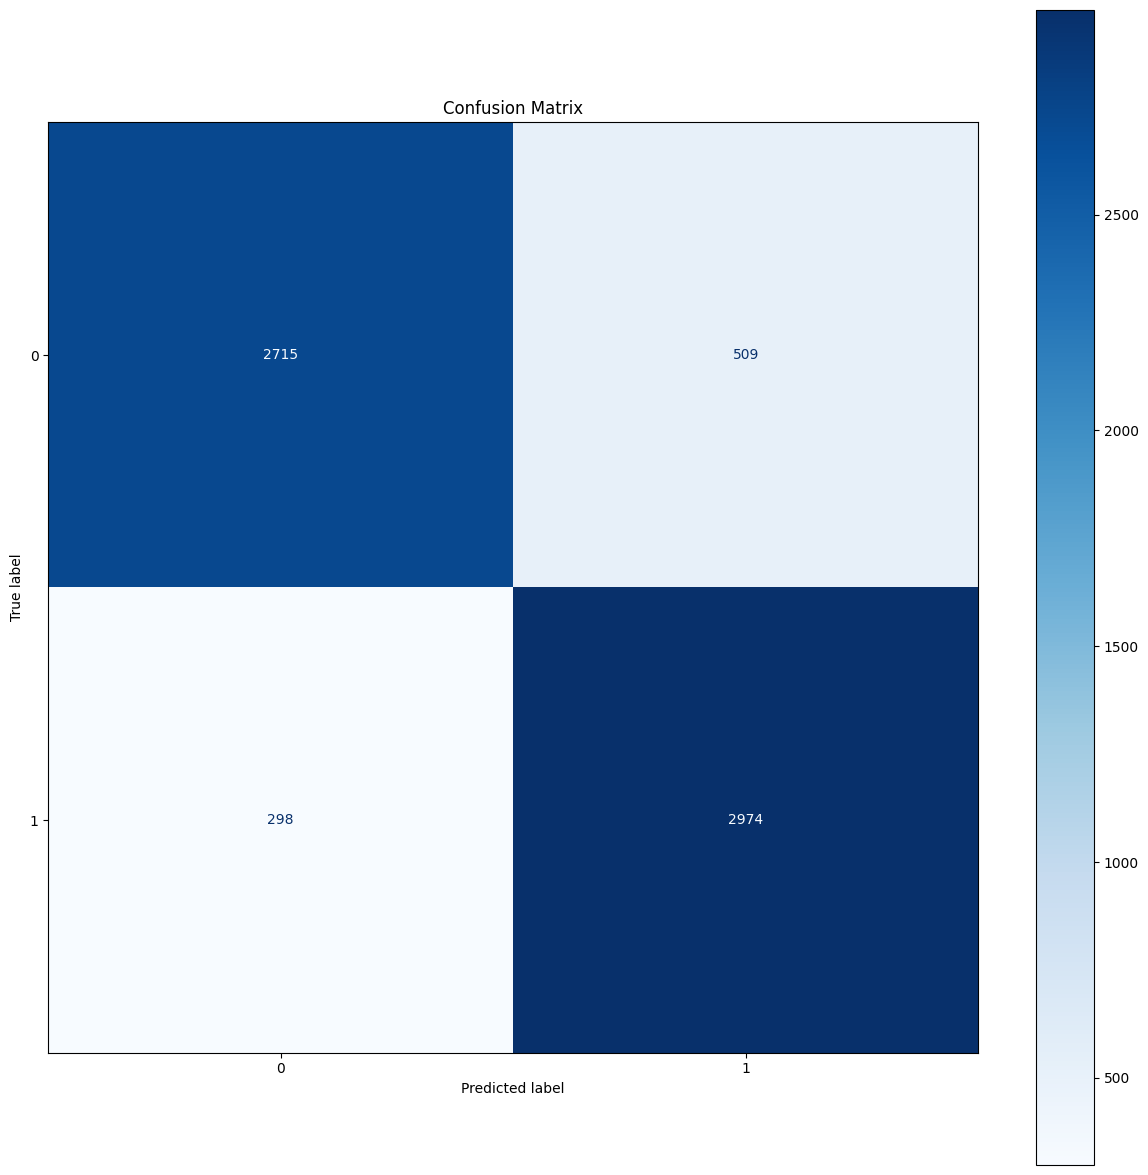

In [65]:
conf_matrix = show_confusion_matrix(y_pred_clean.cpu(), y_true.cpu(), CLASSES)

## Validate on whole dataset (ground)

In [67]:
# merge contact_df and contact_image_df
full_train_df = train_contact_df_reduced.merge(contact_image_endzone_df, 
                                 left_on=['contact_id'], 
                                 right_on=['contact_id'], 
                                 how='left').drop_duplicates()
# use only the rows where the crop was generated
full_train_df = full_train_df[full_train_df['crop_generated'] == True]
# get the ground contacts
full_train_df = full_train_df[full_train_df['nfl_player_id_2'] == -1]


full_train_df

,contact_id,game_play,step,nfl_player_id_1,nfl_player_id_2,game_key,play_id,datetime,team_1,position_1,...,direction_2,orientation_2,acceleration_2,sa_2,p2p_distance,contact_truth,crop_generated,rewinded_frames,miss_helmet_dets,miss_player_dets
12,58168_003392_0_38590_G,58168_003392,0,38590,-1,58168,3392,2020-09-11 03:01:48.100000+00:00,home,G,...,0.0,0.0,0.0,0.0,999.0,0,True,0.0,0.0,0.0
13,58168_003392_0_43854_G,58168_003392,0,43854,-1,58168,3392,2020-09-11 03:01:48.100000+00:00,away,OLB,...,0.0,0.0,0.0,0.0,999.0,0,True,0.0,0.0,0.0
14,58168_003392_0_41257_G,58168_003392,0,41257,-1,58168,3392,2020-09-11 03:01:48.100000+00:00,away,CB,...,0.0,0.0,0.0,0.0,999.0,0,True,0.0,0.0,0.0
15,58168_003392_0_41944_G,58168_003392,0,41944,-1,58168,3392,2020-09-11 03:01:48.100000+00:00,away,DT,...,0.0,0.0,0.0,0.0,999.0,0,True,0.0,0.0,0.0
16,58168_003392_0_42386_G,58168_003392,0,42386,-1,58168,3392,2020-09-11 03:01:48.100000+00:00,away,ILB,...,0.0,0.0,0.0,0.0,999.0,0,True,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660529,58582_003121_91_52493_G,58582_003121,91,52493,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,away,FS,...,0.0,0.0,0.0,0.0,999.0,0,True,10.0,0.0,0.0
660531,58582_003121_91_45287_G,58582_003121,91,45287,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,away,CB,...,0.0,0.0,0.0,0.0,999.0,0,True,10.0,0.0,0.0
660532,58582_003121_91_46105_G,58582_003121,91,46105,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,away,MLB,...,0.0,0.0,0.0,0.0,999.0,0,True,60.0,0.0,1.0
660535,58582_003121_91_52500_G,58582_003121,91,52500,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,home,WR,...,0.0,0.0,0.0,0.0,999.0,0,True,10.0,0.0,0.0


In [75]:
# dataset and loader
# train
p_g_contact_dataset_full = PlayerContactDataset(DATA_PATH, full_train_df, 'Endzone', image_transform_test)

loader_full = DataLoader(p_g_contact_dataset_full,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0,
                         drop_last=True)

In [80]:
# load model
best_model_path = os.path.join(MODEL_DIR, 'bm_efficientnet_CLS_ground_v2_epoch_28.pth')
best_model = load_model(best_model_path, 1, DEVICE)

C:\Users\AT016638\.conda\envs\contact\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\AT016638\.conda\envs\contact\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
# inference on full dataset
val_loss_hist = Averager()
criterion = nn.BCEWithLogitsLoss()
y_pred, y_true = validate_model(best_model, loader_full, criterion,
                                    DEVICE, val_loss_hist)

  0%|          | 0/10162 [00:00<?, ?it/s]

In [94]:
((y_pred_clean == 0) & (y_pred_clean == y_true)).sum()

tensor(302159, device='cuda:0')

In [82]:
# mathews correlation coefficient

thresholds = np.arange(0.0, 0.5, 0.01)
best_score = 0
best_thrs = -1
for thrs in thresholds:
    y_pred_clean = (torch.sigmoid(y_pred) > thrs).double()
    score = matthews_corrcoef(y_pred_clean.cpu(), y_true.cpu())
    if score > best_score:
        best_score = score
        best_thrs = thrs

y_pred_clean = (torch.sigmoid(y_pred) > best_thrs).double()
print(f"Best acc threshold: {best_thrs}")
print(f"Matheys corr coef: {best_score:.5f}")

Best acc threshold: 0.31
Matheys corr coef: 0.64716


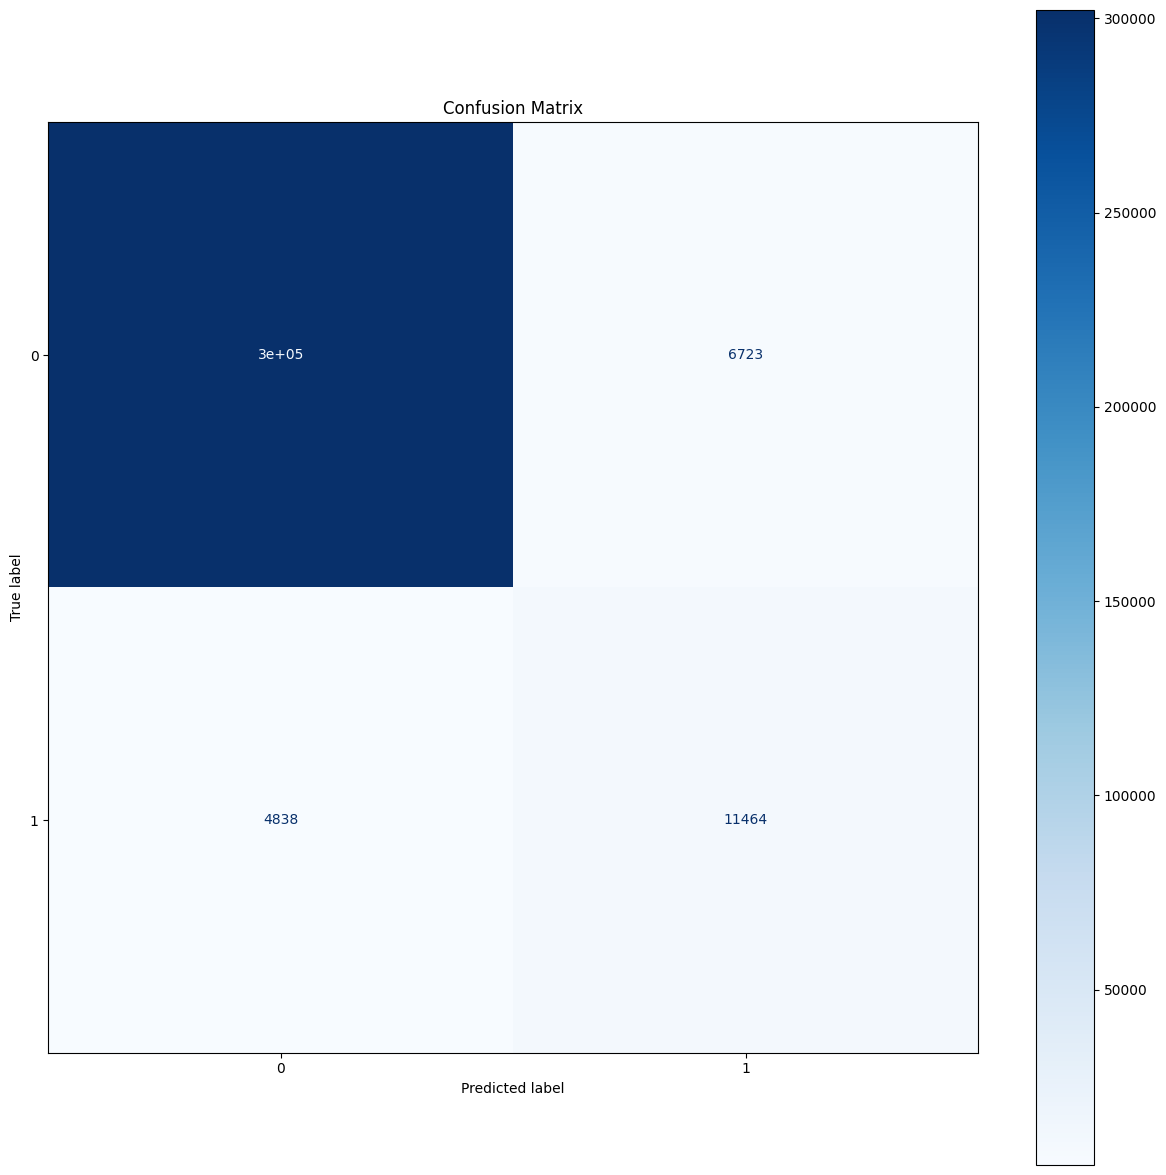

In [83]:
conf_matrix = show_confusion_matrix(y_pred_clean.cpu(), y_true.cpu(), CLASSES)